# Spotify Mood Session

## 1. Algorithm

a. **First Selection**. User selects a song $s_0$ from the set of all songs $S$ using some kind of search method (by name / artist) and plays that song.

b. **Played List**.  Let $P$ be a new list of played songs and let $P \gets s_0$   

c. **Cold Start**. Create a bootstrap random selection of $n$ songs from $S$ called $R$. Calculate the distance between each song and the first selection and select the closest to the chosen song . Formally:

$$
\forall s \in R \text{ dist}(s_i, s_0)
$$

*potential parameter: use a value to add the closest n songs to the initial bootstrap played list*

d. **Rating**. For every song that a user plays for more than 30 seconds, the song is rated $\text{pos}$, songs that are skipped within this time period are rated $\text{neg}$.  Songs that have not been played are rated $\text{non}$

e. **Recommending**.  Take the current set of vectors and select the next song based on some sort of agregated mean or nearest neighbour system.

repeat (d) and (e) ad infinitum.

Formally:

$$
\text{let: } s_0 \gets \text{ user}(S) \\
\text{let: } P = \{ s_0 \} \\
\text{let: } R \subset S \\
\text{let: } D = \emptyset \\ 
\text{for } s_i \text{ in } R:\\
D_i = \text{dist}(s_i, s_0) \\
\text{end for }\\
\text{select}(\text{max}(D))\\
$$

In [12]:
import json
import pandas as pd
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials as cc
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
import time

# create list of playlists
playlists = []
path = 'data'
count = 5
for filename in os.listdir(path):
    count -= 1
    if count < 0:
        break
    f = os.path.join(path, filename)
    if os.path.isfile(f):
        d = json.load(open(f))
        playlists.append(pd.DataFrame(d['playlists']))

playlists = pd.concat(playlists)
playlists = playlists.reset_index(drop=True)
print(playlists.shape)

/tmp/ipykernel_225309/668183663.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/mpd.slice.3000-3999.json' mode='r' encoding='UTF-8'>
  d = json.load(open(f))
/tmp/ipykernel_225309/668183663.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/mpd.slice.4000-4999.json' mode='r' encoding='UTF-8'>
  d = json.load(open(f))
/tmp/ipykernel_225309/668183663.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/mpd.slice.1000-1999.json' mode='r' encoding='UTF-8'>
  d = json.load(open(f))
/tmp/ipykernel_225309/668183663.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/mpd.slice.2000-2999.json' mode='r' encoding='UTF-8'>
  d = json.load(open(f))
/tmp/ipykernel_225309/668183663.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='data/mpd.slice.0-999.json' mode='r' encoding='UTF-8'>
  d = json.load(open(f))


(5000, 12)


In [13]:
# Add all songs from the playlists into a single list of songs
songs = [] 
for i in range(len(playlists)):
    tracks = playlists.iloc[i].loc['tracks']
    for track in tracks:
        songs.append(track)

songs_df = pd.DataFrame(songs)
print(songs_df.shape)
songs_df.head()

(334487, 8)


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,Lost Frequencies,spotify:track:2vCtiBvJJZfz773yTfAxPP,spotify:artist:7f5Zgnp2spUuuzKplmRkt7,What Is Love 2016 - Mike Mago Remix,spotify:album:4N1e8k2o2NN932Y8xgZV1p,209882,What Is Love 2016
1,1,John Legend,spotify:track:5WOLZP8KrXiupBjG1SSN5U,spotify:artist:5y2Xq6xcjJb2jVM54GHK3t,Love Me Now - Dave Audé Remix Radio Edit,spotify:album:2CFZOjwtV7B6XzULEwIdHN,219106,Love Me Now (Remixes)
2,2,July Child,spotify:track:0oQDQ9QiqsO63EEBAro8Le,spotify:artist:3Jghk94Gog2dhBAO7ZZaM8,Thinkin of U,spotify:album:2i0oT2HtRN4o3P45zQjel7,194000,Thinkin of U
3,3,Tiësto,spotify:track:7MUS0La2IQ85vJ59fQqtoN,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,I Will Be Here - (Wolfgang Gartner Remix),spotify:album:2qY9UxNEbQR2O2ECc3Fd48,237066,Kaleidoscope Remixed
4,4,Joe Stone,spotify:track:3ciyZYofjiqmMUElM5qgGB,spotify:artist:4kwEd1P9j15ZqUVP5zK7Pv,The Party (This Is How We Do It),spotify:album:3SBDe6WBbEXNtjraPxXLOh,185807,The Party (This Is How We Do It)


In [14]:
# Remove duplicate songs by URI
songs_df = songs_df.drop_duplicates('track_uri')

In [15]:
# Add score placeholder to the songs
classification = [0]*len(songs_df)
songs_df.insert(8, "class", classification) # Append data frame by one column

In [16]:
# Print song data to ensure the score was added
print(songs_df.iloc[0])

pos                                                0
artist_name                         Lost Frequencies
track_uri       spotify:track:2vCtiBvJJZfz773yTfAxPP
artist_uri     spotify:artist:7f5Zgnp2spUuuzKplmRkt7
track_name       What Is Love 2016 - Mike Mago Remix
album_uri       spotify:album:4N1e8k2o2NN932Y8xgZV1p
duration_ms                                   209882
album_name                         What Is Love 2016
class                                              0
Name: 0, dtype: object


In [17]:
#DO NOT RUN THE AUDIO FEATURES HAVE ALREADY BEEN STORED IN THE AUDIO_FEATURES FILE
def run_features():
    #CREATE DATASET WITH SONG AUDIO FEATURES FROM THE URIS OF songs_df
    client_id = '898dd71dc932407e85921f0ac79f0127'
    client_secret = '16d994f070064371beb8758f32d64180'
    #https://developer.spotify.com/dashboard/applications/898dd71dc932407e85921f0ac79f0127
    client_cc = cc(client_id=client_id,client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_cc)


    sleep_min = 1
    sleep_max = 2
    start_time = time.time()
    request_count = 0
    tracks_w_features = pd.DataFrame()
    for i in range(0,3344):
        if request_count % 13 == 0:
            time.sleep(np.random.uniform(sleep_min, sleep_max))
        else:
            tracks_to_get = songs_df.iloc[request_count:request_count+100]["track_uri"] #get the uri of these songs to get audio features
            tracks = pd.DataFrame(sp.audio_features(tracks_to_get))
            tracks_w_features = tracks_w_features.append(tracks)
        request_count+=100

    #remove useless-categorical columns, can use index to get song information later
    tracks_w_features = tracks_w_features.drop(columns=['mode','key','time_signature', 'duration_ms','analysis_url','track_href','id','type']).copy()
    warnings.filterwarnings("ignore")
    warnings.filterwarnings(action='once')

    from pathlib import Path
    filepath = Path('recommender-systems/audio_features.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    tracks_w_features.to_csv(filepath)

tracks_w_features = pd.read_csv('recommender-systems/audio_features.csv')
tracks_w_features = tracks_w_features.drop(columns=['Unnamed: 0','0'])
display(tracks_w_features.head())

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,uri,valence
0,0.5440,0.628,0.284,0.000005,0.1210,-11.629,0.1020,91.131,spotify:track:6ToAD7ajJidQTDn72OncDG,0.354
1,0.4110,0.758,0.402,0.000000,0.2170,-5.066,0.0459,92.109,spotify:track:6yEfq48XkEzCg0TwY6Hhkb,0.519
2,0.0615,0.756,0.922,0.000462,0.0723,-2.683,0.0539,100.005,spotify:track:1ZgfAxHQCXLt8o1VXEHHAt,0.809
3,0.0222,0.694,0.748,0.000000,0.1550,-2.930,0.1670,92.918,spotify:track:4b1sQpvL7QVgamRZ74F1oA,0.521
4,0.7260,0.538,0.436,0.000000,0.1510,-8.730,0.0504,87.111,spotify:track:0AO2yQNGcH0ASHHU5lS4lT,0.370


array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>]], dtype=object)

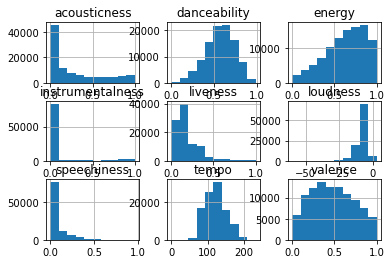

In [19]:
# Investigate data
tracks_w_features.hist()

In [7]:
# Search for a particular song 
print("Search for a song name")
s = input()
pattern = [s]

# filter for rows that contain the partial string inputted by the user
results = songs_df.copy()
results[songs_df.track_name.str.contains('|'.join(pattern))]

Search for a song name


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,class
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0
7,7,The Pussycat Dolls,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,Buttons,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560,PCD,0
11,11,Jesse McCartney,spotify:track:4Y45aqo9QMa57rDsAJv40A,spotify:artist:2Hjj68yyUPiC0HKEOigcEp,Right Where You Want Me - Radio Edit Version,spotify:album:6022khQj4Fsvvse8f3A4lF,211693,Right Where You Want Me,0
...,...,...,...,...,...,...,...,...,...
334480,13,Lenka,spotify:track:62FaMvOq3vLJTBjb5RgxiO,spotify:artist:5g3uG8zZZANGT6YOssgjfC,Like A Song,spotify:album:2n2VzyRpAty4hkMHBx1nV0,200173,Lenka,0
334482,15,Jay Ungar,spotify:track:5YUeOSawPzseEvCvi1HbrE,spotify:artist:54jNT6jMGDoxMSBzUDEYSB,Cows On The Hill,spotify:album:38D9S6sriWlYlbUBONInpa,225440,"Waltzing With You (Music From The Film ""Brothe...",0
334483,16,Solas,spotify:track:4aAmDp1AR1Fp1UCpWuvy2d,spotify:artist:2CGGUtRYybRjQmuUwXugeP,Crested Hens,spotify:album:1EL10LDAWFZdencyTUlGqu,314186,Solas,0
334484,17,Kim Yoon,spotify:track:25JRhSij3kxAJ1li9lPe5k,spotify:artist:2wA50FpX5Yc5b4OrhdQVXP,Moonlight Waltz,spotify:album:6pFFE9TLlHpeQrvOVNiswy,226925,Dreaming in the Blue Sky,0


In [74]:
import max_marg_relevance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import laplacian_kernel

# Ask the user to enter a track URI for the first song they want to play
print("Select your first song by copying the track_URI from above (i.e. spotify:track:2wSAWEYUHkt92X4SBAPqZE)")
#s = input()
s = "spotify:track:6bLopGnirdrilrpdVB6Um1"

# Mark this song as "Played" with a positive rating (as the user chose it)
index = tracks_w_features.index[tracks_w_features['uri'] == s]     # This returns the song with the uri of 's'
def getRecommendation(songs_df, tracks_w_features):

    liked_songs_nofeatures = songs_df.loc[songs_df['class'] == 1]
    liked_songs_uris = liked_songs_nofeatures['track_uri'].to_numpy()

    #Now we get uris of the songs the user liked we can get the features from the feature dataframe
    liked_song_features = pd.DataFrame()
    for i in liked_songs_uris:
        song_with_features = tracks_w_features.loc[tracks_w_features['uri'] == i]
        liked_songs_features = liked_song_features.append(song_with_features)

    liked_song_features = liked_songs_features.drop(columns=['uri'])

    average_session_songs = liked_song_features[['acousticness','danceability','energy','instrumentalness','liveness',
                                                      'loudness','speechiness','tempo','valence']].mean()


    return maximal_marginal_relevance(average_session_songs,tracks_w_features.sample(n=20))

def maximal_marginal_relevance(v1,songs, lambda_constant=0.5, threshold_terms=1, sim = True):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param v1: query vector
    :param songs: matrix having index as songs and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked songs with score
    """

    s = []
    r = songs['uri'].tolist()
    while len(r) > 0:
        score = 0
        song_to_add = None
        for i in r:
            row = songs.loc[songs['uri'] == i]
            row = row.drop(columns=['uri'])
            row = row.to_numpy()
            if len(row) < 1:
              r.remove(i)
              break
            if sim:
                first_part = cosine_similarity([v1], [row[0]])
            else:
                first_part = laplacian_kernel([v1], [row[0]])
            second_part = 0
            for j in s:
                row2 = songs.loc[songs['uri'] == j[0]]
                row2 = row2.drop(columns=['uri'])
                row2 = row2.to_numpy()
                if sim:
                    sim = cosine_similarity([row[0]],[row2[0]])
                else:
                    sim = laplacian_kernel([row[0]], [row2[0]])
                if sim > second_part:
                    second_part = sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                song_to_add = i
        if song_to_add is None:
            song_to_add = i
        r.remove(song_to_add)
        s.append((song_to_add, score))
    return s[:threshold_terms][0][0]


continue_ = True
current_song_index = songs_df.index[songs_df['track_uri'] == s].tolist()[0]

while continue_:
    current_song_artist = songs_df.iloc[current_song_index]["artist_name"]
    current_song_name = songs_df.iloc[current_song_index]["track_name"]
    s = input(current_song_artist + "-" + current_song_name + "\n" + "Skip (y) or listen (n) or quit (q)?")
    if s == "y":
        print("skipped")
        songs_df.at[current_song_index, "class"] = -1 # negative rating
    elif s == "n":
        print("not skipped")
        songs_df.at[current_song_index, "class"] = 1  # positive rating
    elif s == "q":
        continue_ = False
    else:
        print("Invalid input")
    uri = getRecommendation(songs_df,tracks_w_features)
    current_song_index = songs_df.index[songs_df['track_uri'] == uri].tolist()[0]
    print(current_song_index)

Select your first song by copying the track_URI from above (i.e. spotify:track:2wSAWEYUHkt92X4SBAPqZE)
not skipped
63520
not skipped
118880


IndexError: single positional indexer is out-of-bounds